# Probabilistic Forecasting with `sktime`

### Overview of this notebook

* quick start - probabilistic forecasting
* disambiguation - types of probabilistic forecasts
* details: probabilistic forecasting interfaces
* metrics for, and evaluation of probabilistic forecasts
* advanced composition: pipelines, tuning, reduction
* extender guide
* contributor credits

In [1]:
import warnings
warnings.filterwarnings('ignore')

---
### Quick Start - Probabilistic Forecasting with `sktime`

... works exactly like the basic forecasting workflow, replace `predict` by a probabilistic method!

In [2]:
from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon

# step 1: data specification
y = load_airline()
# step 2: specifying forecasting horizon
fh = [1, 2, 3]
# step 3: specifying the forecasting algorithm
forecaster = ARIMA()
# step 4: fitting the forecaster
forecaster.fit(y, fh=[1,2,3])
# step 5: querying predictions
y_pred = forecaster.predict()

# for probabilistic forecasting:
#   call a probabilistic forecasting method after or instead of step 5
y_pred_int = forecaster.predict_interval(coverage=0.9)
y_pred_int

Coverage            
                0.9            
              lower       upper
1961-01  371.535092  481.554608
1961-02  344.853205  497.712760
1961-03  324.223995  508.191103

**probabilistic forecasting methods in `sktime`**:

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* forecast variance     - `predict_var(fh=None, X=None, cov=False)`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

To check which forecasters in `sktime` support probabilistic forecasting, use the `registry.all_estimators` utility and search for estimators which have the `capability:pred_int` tag (value `True`).

For composites such as pipelines, a positive tag means that logic is implemented if (some or all) components support it.

In [3]:
from sktime.registry import all_estimators

all_estimators("forecaster", filter_tags={"capability:pred_int": True}, as_dataframe=True)

Importing plotly failed. Interactive plots will not work.


,name,estimator
0,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
1,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,BATS,<class 'sktime.forecasting.bats.BATS'>
4,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
5,ForecastingGridSearchCV,<class 'sktime.forecasting.model_selection._tu...
6,ForecastingPipeline,<class 'sktime.forecasting.compose._pipeline.F...
7,ForecastingRandomizedSearchCV,<class 'sktime.forecasting.model_selection._tu...
8,MockUnivariateForecaster,<class 'sktime.utils.estimators._forecasters.M...
9,NaiveVariance,<class 'sktime.forecasting.naive.NaiveVariance'>


---
### What is probabilistic forecasting?

#### Intuition

* produce low/high scenarios of forecasts
* quantify uncertainty around forecasts
* produce expected range of variation of forecasts

#### Interface view

**Want** to produce "distribution" or "range" of forecast values,

at time stamps defined by **forecasting horizon** `fh`

given **past data** `y` (series), and possibly exogeneous data `X`

Input, to `fit` or `predict`: `fh`, `y`, `X`

Output, from `predict_probabilistic`: some "distribution" or "range" object

**Big caveat**: there are multiple possible ways to model "distribution" or "range"!

Used in practice and easily confused! (and often, practically, confused!)

#### Formal view (endogeneous, one forecast time stamp)

Let  $y(t_1), \dots, y(t_n)$ be observations at fixed time stamps $t_1, \dots, t_n$. 

(we consider $y$ as an $\mathbb{R}^n$-valued random variable)

Let $y'$ be a (true) value, which will be observed at a future time stamp $\tau$.

(we consider $y'$ as an $\mathbb{R}$-valued random variable)

We have the following "types of forecasts" of $y'$:

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

Notes:

* different forecasters have different capabilities!
* metrics, evaluation & tuning are different by "type of forecast"
* compositors can "add" type of forecast! Example: bootstrap

##### More formal details & intuition:

* a **"point forecast"** is a prediction/estimate of the conditional expectation $\mathbb{E}[y'|y]$.\
 **Intuition**: "out of many repetitions/worlds, this value is the arithmetic average of all observations".
* a **"variance forecast"** is a prediction/estimate of the conditional expectation $Var[y'|y]$.\
 **Intuition:** "out of many repetitions/worlds, this value is the average squared distance of the observation to the perfect point forecast".
* a **"quantile forecast"**, at quantile point $\alpha\in (0,1)$ is a prediction/estimate of the $\alpha$-quantile of $y'|y$, i.e., of $F^{-1}_{y'|y}(\alpha)$, where $F^{-1}$ is the (generalized) inverse cdf = quantile function of the random variable y'|y.\
 **Intuition**: "out of many repetitions/worlds, a fraction of exactly $\alpha$ will have equal or smaller than this value."
* an **"interval forecast"** or "predictive interval" with (symmetric) coverage $c\in (0,1)$ is a prediction/estimate pair of lower bound $a$ and upper bound $b$ such that $P(a\le y' \le b| y) = c$ and $P(y' \gneq b| y) = P(y' \lneq a| y) = (1 - c) /2$.\
 **Intuition**: "out of many repetitions/worlds, a fraction of exactly $c$ will be contained in the interval $[a,b]$, and being above is equally likely as being below".
* a **"distribution forecast"** or "full probabilistic forecast" is a prediction/estimate of the distribution of $y'|y$, e.g., "it's a normal distribution with mean 42 and variance 1".\
**Intuition**: exhaustive description of the generating mechanism of many repetitions/worlds.

Notes:

* lower/upper of interval forecasts are quantile forecasts at quantile points $0.5 - c/2$ and $0.5 + c/2$ (as long as forecast distributions are absolutely continuous).
* all other forecasts can be obtained from a full probabilistic forecasts; a full probabilistic forecast can be obtained from all quantile forecasts or all interval forecasts.
* there is no exact relation between the other types of forecasts (point or variance vs quantile)
* in particular, point forecast does not need to be median forecast aka 0.5-quantile forecast. Can be $\alpha$-quantile for any $\alpha$!

Frequent confusion in literature & python packages:
* coverage `c` vs quantile `\alpha`
* coverage `c` vs significance `p = 1-c`
* quantile of lower interval bound, `p/2`, vs `p`
* interval forecasts vs related, but substantially different concepts: confidence interval on predictive mean; Bayesian posterior or credibility interval of the predictive mean
* all forecasts above can be Bayesian, confusion: "posteriors are different" or "have to be evaluted differently"

---
### Probabilistic forecasting interfaces in `sktime` 

This section:

* walkthrough of probabilistic predict methods
* use in update/predict workflow
* multivariate and hierarchical data

All forecasters with tag `capability:pred_int` provide the following:

* forecast intervals    - `predict_interval(fh=None, X=None, coverage=0.90)`
* forecast quantiles    - `predict_quantiles(fh=None, X=None, alpha=[0.05, 0.95])`
* forecast variance     - `predict_var(fh=None, X=None, cov=False)`
* distribution forecast - `predict_proba(fh=None, X=None, marginal=True)`

Generalities:

* methods do not change state, multiple can be called
* `fh` is optional, if passed late
* exogeneous data `X` can be passed

In [4]:
import numpy as np

from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

# until fit, identical with the simple workflow
y = load_airline()

fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=fh)

ThetaForecaster(sp=12)

##### `predict_interval` - interval predictions

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\
`coverage`, float or list of floats, default=`0.9`\
nominal coverage(s) of the prediction interval(s) queried

Output: `pandas.DataFrame`\
Row index is `fh`\
Column has multi-index:\
1st level = variable name from y in fit\
2nd level = coverage fractions in `coverage`\
3rd level = string "lower" or "upper"\

Entries = forecasts of lower/upper interval at nominal coverage in 2nd lvl, for var in 1st lvl, for time in row

In [5]:
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Coverage            
                0.9            
              lower       upper
1961-01  418.280122  464.281951
1961-02  402.215882  456.888054
1961-03  459.966115  522.110499
1961-04  442.589311  511.399213
1961-05  443.525029  518.409479
1961-06  506.585817  587.087736
1961-07  561.496771  647.248955
1961-08  557.363326  648.062361
1961-09  477.658059  573.047750
1961-10  407.915093  507.775353
1961-11  346.942927  451.082014
1961-12  394.708224  502.957139

pretty-plotting the predictive interval forecasts:

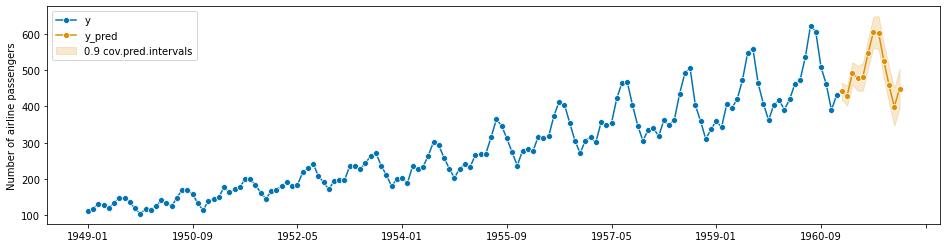

In [6]:
from sktime.utils import plotting

# also requires predictions
y_pred = forecaster.predict()

fig, ax = plotting.plot_series(y, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["Coverage"][coverage]["lower"],
    y_pred_ints["Coverage"][coverage]["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage} cov.pred.intervals",
)
ax.legend();

multiple coverages:

In [7]:
coverage = [0.5, 0.9, 0.95]
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Coverage                                                  \
               0.50                    0.90                    0.95   
              lower       upper       lower       upper       lower   
1961-01  431.849267  450.712807  418.280122  464.281951  413.873757   
1961-02  418.342515  440.761422  402.215882  456.888054  396.979013   
1961-03  478.296823  503.779790  459.966115  522.110499  454.013506   
1961-04  462.886145  491.102379  442.589311  511.399213  435.998234   
1961-05  465.613671  496.320837  443.525029  518.409479  436.352092   
1961-06  530.331442  563.342111  506.585817  587.087736  498.874800   
1961-07  586.791065  621.954661  561.496771  647.248955  553.282848   
1961-08  584.116791  621.308896  557.363326  648.062361  548.675560   
1961-09  505.795125  544.910684  477.658059  573.047750  468.520991   
1961-10  437.370842  478.319604  407.915093  507.775353  398.349804   
1961-11  377.660800  420.364141  346.942927  451.082014  336.967783   
1961-12  426.638371  471.026992  394.708224  502.957139  384.339413   

                     
                     
              upper  
1961-01  468.688317  
1961-02  462.124924  
1961-03  528.063108  
1961-04  517.990290  
1961-05  525.582417  
1961-06  594.798752  
1961-07  655.462877  
1961-08  656.750127  
1961-09  582.184818  
1961-10  517.340642  
1961-11  461.057158  
1961-12  513.325951

##### `predict_quantiles` - quantile forecasts

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\
`alpha`, float or list of floats, default = `[0.1, 0.9]`\
quantile points at which quantiles are queried

Output: `pandas.DataFrame`\
Row index is `fh`\
Column has multi-index:\
1st level = variable name from y in fit\
2nd level = quantile points in `alpha`\

Entries = forecasts of quantiles at quantile point in 2nd lvl, for var in 1st lvl, for time in row

In [8]:
alpha = [0.1, 0.25, 0.5, 0.75, 0.9]
y_pred_quantiles = forecaster.predict_quantiles(alpha=alpha)
y_pred_quantiles

Quantiles                                                
               0.10        0.25        0.50        0.75        0.90
1961-01  423.360379  431.849267  441.281037  450.712807  459.201694
1961-02  408.253657  418.342515  429.551968  440.761422  450.850279
1961-03  466.829091  478.296823  491.038307  503.779790  515.247523
1961-04  450.188400  462.886145  476.994262  491.102379  503.800124
1961-05  451.794967  465.613671  480.967254  496.320837  510.139541
1961-06  515.476126  530.331442  546.836776  563.342111  578.197427
1961-07  570.966898  586.791065  604.372863  621.954661  637.778828
1961-08  567.379763  584.116791  602.712844  621.308896  638.045924
1961-09  488.192513  505.795125  525.352904  544.910684  562.513296
1961-10  418.943260  437.370842  457.845223  478.319604  496.747186
1961-11  358.443630  377.660800  399.012471  420.364141  439.581311
1961-12  406.662800  426.638371  448.832682  471.026992  491.002564

pretty-plotting the quantile interval forecasts:

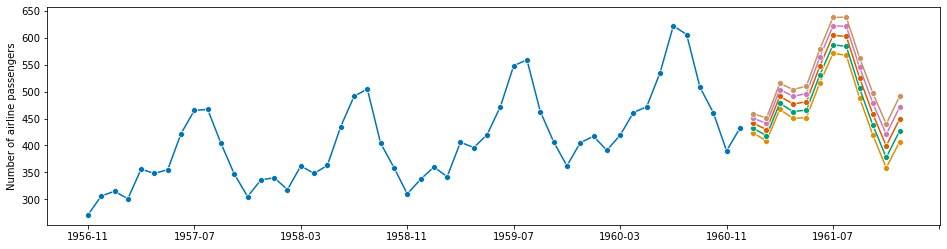

In [9]:
from sktime.utils import plotting

_, columns = zip(*y_pred_quantiles.iteritems())
fig, ax = plotting.plot_series(y[-50:], *columns)


##### `predict_var` - variance forecasts

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\
`cov`, boolean, default=False\
whether covariance forecasts should also be returned (not all estimators support this)

Output: `pandas.DataFrame`, for cov=False:\
Row index is `fh`\
Column is equal to column index of `y` (variables)

Entries = variance forecast for variable in col, for time in row

In [10]:
y_pred_variance = forecaster.predict_var()
y_pred_variance

,0
1961-01,195.540039
1961-02,276.196489
1961-03,356.852938
1961-04,437.509388
1961-05,518.165837
1961-06,598.822287
1961-07,679.478737
1961-08,760.135186
1961-09,840.791636
1961-10,921.448085


with covariance, using a forecaster which can return covariance forecasts:

return is `pandas.DataFrame` with `fh` indexing rows and columns;\
entries are forecast covariance between row and column time\
(diagonal = forecast variances)

In [11]:
from sktime.forecasting.naive import NaiveVariance

forecaster_with_covariance = NaiveVariance(forecaster)
forecaster_with_covariance.fit(y=y, fh=fh)
forecaster_with_covariance.predict_var(cov=True)

,1961-01,1961-02,1961-03,1961-04,1961-05,1961-06,1961-07,1961-08,1961-09,1961-10,1961-11,1961-12
1961-01,180.037627,139.823819,138.680090,155.471163,94.854135,79.164196,103.726381,73.927190,42.536102,50.640321,24.244839,48.719841
1961-02,139.823819,292.337332,255.742996,264.805442,227.703060,146.093856,154.452831,157.976793,105.160758,78.330258,81.835796,78.048890
1961-03,138.680090,255.742996,422.704612,402.539267,353.437063,291.205422,236.587888,227.199381,205.653011,152.067429,121.629135,156.199130
1961-04,155.471163,264.805442,402.539267,588.085339,506.095474,426.997529,394.503935,311.457843,282.072144,243.688603,185.938835,185.070378
1961-05,94.854135,227.703060,353.437063,506.095474,634.350468,526.180904,482.653113,422.777317,323.453748,280.749324,242.065793,211.397190
1961-06,79.164196,146.093856,291.205422,426.997529,526.180904,628.659368,570.277539,499.460196,419.166449,325.582787,281.608606,269.847463
1961-07,103.726381,154.452831,236.587888,394.503935,482.653113,570.277539,728.132509,629.184845,527.767032,444.690523,330.643651,313.248446
1961-08,73.927190,157.976793,227.199381,311.457843,422.777317,499.460196,629.184845,753.550001,629.138714,536.407563,441.998592,352.570978
1961-09,42.536102,105.160758,205.653011,282.072144,323.453748,419.166449,527.767032,629.138714,729.423283,615.142475,506.155589,439.994842
1961-10,50.640321,78.330258,152.067429,243.688603,280.749324,325.582787,444.690523,536.407563,615.142475,744.225548,609.227118,527.489583


##### `predict_proba` - distribution forecasts aka "full" probabilistic forecasts

Inputs:\
`fh` - forecasting horizon (not necessary if seen in `fit`)\
`marginal`, bool, optional, default=True\
whether returned distribution is marginal over time points (True), or joint over time points (False)\
(not all forecasters support `marginal=False`)

Output: `tensorflow-probability` `Distribution` object (requires `tensorflow` installed)\
if `marginal=True`: batch shape 1D, `len(fh)` (time); event shape 1D, `len(y.columns)` (variables)\
if `marginal=False`: event shape 2D, `[len(fh), len(y.columns)]`

In [12]:
y_pred_dist = forecaster.predict_proba()
y_pred_dist

<tfp.distributions.Normal 'Normal' batch_shape=[12, 1] event_shape=[] dtype=float32>

In [13]:
# obtaining quantiles
y_pred_dist.quantile([0.1, 0.9])

<tf.Tensor: shape=(12, 2), dtype=float32, numpy=
array([[423.36038, 459.2017 ],
       [408.25366, 450.85028],
       [466.82907, 515.2475 ],
       [450.18842, 503.8001 ],
       [451.79498, 510.13953],
       [515.47614, 578.19745],
       [570.9669 , 637.7788 ],
       [567.37976, 638.0459 ],
       [488.1925 , 562.5133 ],
       [418.94324, 496.74716],
       [358.44363, 439.5813 ],
       [406.66278, 491.00253]], dtype=float32)>

In [14]:
# obtaining distribution parameters

y_pred_dist.parameters

{'loc':                   0
 1961-01  441.281037
 1961-02  429.551968
 1961-03  491.038307
 1961-04  476.994262
 1961-05  480.967254
 1961-06  546.836776
 1961-07  604.372863
 1961-08  602.712844
 1961-09  525.352904
 1961-10  457.845223
 1961-11  399.012471
 1961-12  448.832682,
 'scale':                  0
 1961-01  13.983563
 1961-02  16.619160
 1961-03  18.890552
 1961-04  20.916725
 1961-05  22.763256
 1961-06  24.470846
 1961-07  26.066813
 1961-08  27.570549
 1961-09  28.996407
 1961-10  30.355363
 1961-11  31.656035
 1961-12  32.905334,
 'validate_args': False,
 'allow_nan_stats': True,
 'name': 'Normal'}

##### a note on consistence of methods

Outputs of `predict_interval`, `predict_quantiles`, `predict_var`, `predict_proba` are *typically* but not *necessarily* consistent with each other!

Consistency is weak interface requirement but not strictly enforced.

#### Using probabilistic forecasts with update/predict stream workflow

Example:
* data observed monthly
* make probabilistic forecasts for an entire year ahead
* update forecasts every month
* start in Dec 1950

In [15]:
# 1949 and 1950
y_start = y[:24]
# Jan 1951 etc
y_update_batch_1 = y.loc[["1951-01"]]
y_update_batch_2 = y.loc[["1951-02"]]
y_update_batch_3 = y.loc[["1951-03"]]

In [16]:
# now = Dec 1950

# 1a. fit to data available in Dec 1950
#   fh = [1, 2, ..., 12] for all 12 months ahead
forecaster.fit(y_start, fh=1+np.arange(12))

# 1b. predict 1951, in Dec 1950
forecaster.predict_interval()
# or other proba predict functions


Coverage            
                0.9            
              lower       upper
1951-01  125.708000  141.744256
1951-02  135.554587  154.422387
1951-03  149.921348  171.248005
1951-04  140.807416  164.337369
1951-05  127.941096  153.485001
1951-06  152.968276  180.378557
1951-07  167.193934  196.351366
1951-08  166.316510  197.122163
1951-09  150.425514  182.795572
1951-10  128.623029  162.485295
1951-11  109.567279  144.858715
1951-12  125.641287  162.306228

In [17]:
# time passes, now = Jan 1951

# 2a. update forecaster with new data
forecaster.update(y_update_batch_1)

# 2b. make new prediction - year ahead = Feb 1951 to Jan 1952
forecaster.predict_interval()
# forecaster remembers relative forecasting horizon

Coverage            
                0.9            
              lower       upper
1951-02  136.659400  152.695656
1951-03  150.894542  169.762342
1951-04  141.748827  163.075484
1951-05  128.876521  152.406474
1951-06  153.906406  179.450311
1951-07  168.170068  195.580349
1951-08  167.339647  196.497079
1951-09  151.478086  182.283739
1951-10  129.681612  162.051670
1951-11  110.621197  144.483463
1951-12  126.786547  162.077984
1952-01  121.345115  158.010056

repeat the same commands with further data batches:

In [18]:
# time passes, now = Feb 1951

# 3a. update forecaster with new data
forecaster.update(y_update_batch_2)

# 3b. make new prediction - year ahead = Feb 1951 to Jan 1952
forecaster.predict_interval()

Coverage            
                0.9            
              lower       upper
1951-03  151.754368  167.790624
1951-04  142.481688  161.349489
1951-05  129.549186  150.875842
1951-06  154.439360  177.969313
1951-07  168.623239  194.167144
1951-08  167.770039  195.180319
1951-09  151.929279  181.086712
1951-10  130.167031  160.972684
1951-11  111.133098  143.503156
1951-12  127.264387  161.126653
1952-01  121.830223  157.121659
1952-02  132.976432  169.641372

In [19]:
# time passes, now = Feb 1951

# 4a. update forecaster with new data
forecaster.update(y_update_batch_3)

# 4b. make new prediction - year ahead = Feb 1951 to Jan 1952
forecaster.predict_interval()

Coverage            
                0.9            
              lower       upper
1951-04  143.421743  159.457999
1951-05  130.401489  149.269290
1951-06  155.166804  176.493460
1951-07  169.300651  192.830603
1951-08  168.451755  193.995660
1951-09  152.643332  180.053613
1951-10  130.913432  160.070865
1951-11  111.900915  142.706569
1951-12  128.054399  160.424458
1952-01  122.645048  156.507314
1952-02  133.834104  169.125540
1952-03  149.605273  186.270213

... and so on.

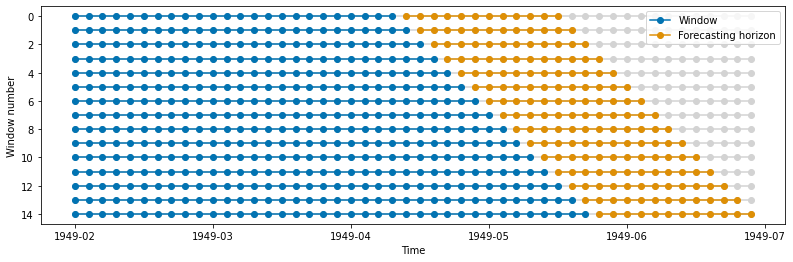

In [20]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from utils import plot_windows

cv = ExpandingWindowSplitter(step_length=1, fh=fh, initial_window=24)
plot_windows(cv, y.iloc[:50])

#

#### Probabilistic forecasting for multivariate and hierarchical data

multivariate data: first column index for different variables

In [21]:
from sktime.forecasting.var import VAR

from sktime.datasets import load_longley

_, y = load_longley()

mv_forecaster = VAR()

mv_forecaster.fit(y, fh=[1,2,3])
# mv_forecaster.predict_var()

VAR()

hierarchical data: probabilistic forecasts per level are row-concatenated with a row hierarchy index

In [22]:
from sktime.utils._testing.hierarchical import _make_hierarchical
from sktime.forecasting.arima import ARIMA

y_hier = _make_hierarchical()
y_hier

c0
h0   h1   time                
h0_0 h1_0 2000-01-01  4.610663
          2000-01-02  6.659800
          2000-01-03  5.407001
          2000-01-04  5.581325
          2000-01-05  5.286879
...                        ...
h0_1 h1_3 2000-01-08  3.997595
          2000-01-09  5.618013
          2000-01-10  3.149076
          2000-01-11  4.931206
          2000-01-12  4.730279

[96 rows x 1 columns]

In [23]:
forecaster = ARIMA()
forecaster.fit(y_hier, fh=[1,2,3])
forecaster.predict_interval()

Coverage          
                           0.9          
                         lower     upper
h0   h1                                 
h0_0 h1_0 2000-01-13  2.869850  7.143973
          2000-01-14  2.859192  7.134683
          2000-01-15  2.858940  7.134431
     h1_1 2000-01-13  3.468361  6.673204
          2000-01-14  3.354769  6.597247
          2000-01-15  3.339760  6.583122
     h1_2 2000-01-13  3.418609  6.716502
          2000-01-14  3.434520  6.734490
          2000-01-15  3.433918  6.733890
     h1_3 2000-01-13  2.953505  5.615582
          2000-01-14  3.172261  6.157614
          2000-01-15  2.940305  6.003420
h0_1 h1_0 2000-01-13  4.152296  6.671778
          2000-01-14  2.827739  5.608764
          2000-01-15  3.358670  6.193605
     h1_1 2000-01-13  4.360761  5.675752
          2000-01-14  4.300884  5.624451
          2000-01-15  4.307187  5.630866
     h1_2 2000-01-13  2.859695  6.463636
          2000-01-14  2.620881  6.667839
          2000-01-15  2.575798  6.730602
     h1_3 2000-01-13  3.298666  5.999875
          2000-01-14  3.242510  6.114556
          2000-01-15  3.221165  6.114759

(more about this in the hierarchical forecasting notebook)

---
### Metrics for probabilistic forecasts and evaluation


#### overview - theory

Predicted `y` has different form from true `y`, so metrics have form

`metric(y_true: series, y_pred: proba_prediction) -> float`

where `proba_prediction` is the type of the specific "probabilistic prediction type".

I.e., we have the following function signature for a loss/metric $L$:

| Name | param | prediction/estimate of | general form |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `metric(y_true, y_pred)` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `metric(y_pred, y_pt, y_var)` (requires point forecast too) |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `metric(y_true, y_quantiles, alpha)` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `metric(y_true, y_interval, c)` |
| distribution forecast | | the law/distribution of $y'\|y$ | `metric(y_true, y_distribution)` |


#### metrics: general signature and averaging

intro using the example of the quantile loss aka interval loss aka pinball loss, in the univariate case.

For one quantile value $\alpha$, the (per-sample) pinball loss function is defined as\
$L_{\alpha}(\widehat{y}, y) := \alpha \cdot \Theta (y - \widehat{y}) + (1-\alpha) \cdot \Theta (\widehat{y} - y)$,\
where $\Theta (x) := [1$ if $x\ge 0$ and $0$ otherwise $]$ is the Heaviside function.

This can be used to evaluate:

* *multiple quantile* forecasts $\widehat{\bf y}:=\widehat{y}_1, \dots, \widehat{y}_k$ for quantiles $\bm{\alpha} = \alpha_1,\dots, \alpha_k$ via\
$L_{\bm{\alpha}}(\widehat{\bf y}, y) := \frac{1}{k}\sum_{i=1}^k L_{\alpha_i}(\widehat{y}_i, y)$
* *interval forecasts* $[\widehat{a}, \widehat{b}]$ at symmetric coverage $c$ via\
$L_c([\widehat{a},\widehat{b}], y) := \frac{1}{2} L_{\alpha_{low}}(\widehat{a}, y) + \frac{1}{2}L_{\alpha_{high}}(\widehat{b}, y)$ where $\alpha_{low} = \frac{1-c}{2}, \alpha_{high} = \frac{1+c}{2}$

(all are known to be strictly proper losses for their respective prediction object)

There are *three things we can choose to average over*:

* quantile values, if multiple are predicted - elements of `alpha` in `predict_interval(fh, alpha)`
* time stamps in the forecasting horizon `fh` - elements of `fh` in `fit(fh)` resp `predict_interval(fh, alpha)`
* variables in `y`, in case of multivariate (later, first we look at univariate)

We will show quantile values and time stamps first:

1. averaging by `fh` time stamps only -> one number per quantile value in `alpha`

2. averaging over nothing -> one number per quantile value in `alpha` and `fh` time stamp

3. averaging over both `fh` and quantile values in `alpha` -> one number


first, generating some quantile predictions.
`pred_quantiles` now contains quantile forecasts\
formally, forecasts $\widehat{y}_j(t_i)$ where $\widehat{y_j}$ are forecasts at quantile $\alpha_j$, with range $i=1\dots N, j=1\dots k$\
$\alpha_j$ are the elements of `alpha`, and $t_i$ are the future time stamps indexed by `fh`

In [24]:
import numpy as np

from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

y_train = load_airline()[0:24] # train on 24 months, 1949 and 1950
y_test = load_airline()[24:36] # ground truth for 12 months in 1951

# try to forecast 12 months ahead, from y_train
fh = np.arange(1, 13)

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train, fh=fh)

pred_quantiles = forecaster.predict_quantiles(alpha=[0.1, 0.25, 0.5, 0.75, 0.9])
pred_quantiles

Quantiles                                                
               0.10        0.25        0.50        0.75        0.90
1951-01  127.478980  130.438209  133.726128  137.014047  139.973276
1951-02  137.638271  141.120016  144.988487  148.856958  152.338703
1951-03  152.276579  156.212065  160.584677  164.957288  168.892775
1951-04  143.405970  147.748039  152.572393  157.396747  161.738816
1951-05  130.762062  135.475773  140.713048  145.950324  150.664035
1951-06  155.995358  161.053478  166.673417  172.293355  177.351475
1951-07  170.413963  175.794492  181.772650  187.750808  193.131336
1951-08  169.718563  175.403243  181.719337  188.035430  193.720110
1951-09  154.000333  159.973699  166.610543  173.247386  179.220753
1951-10  132.362642  138.611371  145.554162  152.496954  158.745683
1951-11  113.464723  119.977182  127.212997  134.448812  140.961271
1951-12  129.690416  136.456333  143.973758  151.491182  158.257099

1. computing the loss by quantile point or interval end, averaged over `fh` time stamps\
i.e., $\frac{1}{N} \sum_{i=1}^N L_{\alpha}(\widehat{y}(t_i), y(t_i))$ for $t_i$ in the `fh`, and every `alpha`,
this is one number per quantile value in `alpha`

In [25]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

loss = PinballLoss(score_average=False)
loss(y_true=y_test, y_pred=pred_quantiles)

,0.10,0.25,0.50,0.75,0.90
0,2.706601,5.494502,8.162434,8.003794,5.220242


2. computing the the individual loss values, by sample, no averaging,\
i.e., $L_{\alpha}(\widehat{y}(t_i), y(t_i))$ for every $t_i$ in `fh` and every $\alpha$ in `alpha`\
this is one number per quantile value $\alpha$ in `alpha` and time point $t_i$ in `fh`

In [26]:
loss.evaluate_by_index(y_true=y_test, y_pred=pred_quantiles)

,0.10,0.25,0.50,0.75,0.90
1951-01,1.752102,3.640448,5.636936,5.989465,4.524051
1951-02,1.236173,2.219996,2.505757,0.857281,0.23387
1951-03,2.572342,5.446984,8.707662,9.782034,8.196503
1951-04,1.959403,3.81299,5.213804,4.20244,1.135066
1951-05,4.123794,9.131057,15.643476,19.537257,19.202369
1951-06,2.200464,4.236631,5.663292,4.279984,0.583672
1951-07,2.858604,5.801377,8.613675,8.436894,5.281797
1951-08,2.928144,5.899189,8.640332,8.223428,4.751901
1951-09,2.999967,6.006575,8.694729,8.06446,4.301323
1951-10,2.963736,5.847157,8.222919,7.127285,2.928886


3. computing the loss for a multiple quantile forecast, averaged over `fh` time stamps and quantile values `alpha`\
i.e., $\frac{1}{Nk} \sum_{j=1}^k\sum_{i=1}^N L_{\alpha_j}(\widehat{y_j}(t_i), y(t_i))$ for $t_i$ in `fh`, and quantile values $\alpha_j$,\
this is a single number that can be used in tuning (e.g., grid search) or evaluation overall

In [27]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

loss_multi = PinballLoss(score_average=True)
loss_multi(y_true=y_test, y_pred=pred_quantiles)

5.917514634084557

4. computing the loss for a multiple quantile forecast, averaged quantile values `alpha`, for individual time stamps\
i.e., $\frac{1}{k} \sum_{j=1}^k L_{\alpha_j}(\widehat{y_j}(t_i), y(t_i))$ for $t_i$ in `fh`, and quantile values $\alpha_j$,\
this is a univariate time series at `fh` times $t_i$, it can be used for tuning or evaluation by horizon index

In [28]:
loss_multi.evaluate_by_index(y_true=y_test, y_pred=pred_quantiles)

1951-01     4.308600
1951-02     1.410615
1951-03     6.941105
1951-04     3.264740
1951-05    13.527590
1951-06     3.392808
1951-07     6.198469
1951-08     6.088599
1951-09     6.013411
1951-10     5.417996
1951-11     6.470196
1951-12     7.976044
Freq: M, dtype: float64

Question: why is `score_average` a constructor flag, and `evaluate_by_index` a method?

* not all losses are "by index", so `evaluate_by_index` logic can vary (e.g., pseudo-samples)
* constructor args define "mathematical object" of scientific signature: series -> non-temporal object\
methods define action or "way to apply", e.g., as used in tuning or reporting

Compare `score_average` to `multioutput` arg in `scikit-learn` metrics and `sktime`.

#### metrics: interval vs quantile metrics

Interval and quantile metrics can be used interchangeably:

internally, these are easily convertible to each other\
recall: lower/upper interval = quantiles at $\frac{1}{2} \pm \frac{1}2$ `coverage`

In [29]:
pred_interval = forecaster.predict_interval(coverage = 0.8)
pred_interval

Coverage            
                0.8            
              lower       upper
1951-01  127.478980  139.973276
1951-02  137.638271  152.338703
1951-03  152.276579  168.892775
1951-04  143.405970  161.738816
1951-05  130.762062  150.664035
1951-06  155.995358  177.351475
1951-07  170.413963  193.131336
1951-08  169.718563  193.720110
1951-09  154.000333  179.220753
1951-10  132.362642  158.745683
1951-11  113.464723  140.961271
1951-12  129.690416  158.257099

loss object recognizes input type automatically and computes corresponding interval loss

In [30]:
loss(y_true=y_test, y_pred=pred_interval)

,0.1,0.9
0,2.706601,5.220242


In [31]:
loss_multi(y_true=y_test, y_pred=pred_interval)

3.9634216112066714

#### evaluation by backtesting

In [32]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

# 1. define data
y = load_airline()

# 2. define splitting/backtesting regime
fh = [1, 2, 3]
cv = ExpandingWindowSplitter(step_length=12, fh=fh, initial_window=72)

# 3. define loss to use
loss = PinballLoss()
# default is score_average=True and multi_output="uniform_average", so gives a number

forecaster = ThetaForecaster(sp=12)
results = evaluate(
    forecaster=forecaster, y=y, cv=cv, strategy="refit", return_data=True, scoring=loss
)
results.iloc[:, :5].head()

,test_PinballLoss,fit_time,pred_time,len_train_window,cutoff
0,0.865788,0.022824,0.022832,72,1954-12
1,0.958340,0.022678,0.018509,84,1955-12
2,0.981744,0.021450,0.018745,96,1956-12
3,1.411308,0.023316,0.015046,108,1957-12
4,1.187198,0.019489,0.015389,120,1958-12


* each row is one train/test split in the walkforward setting
* first col is the loss on the test fold
* last two columns summarize length of training window, cutoff between train/test

roadmap items:

implementing further metrics

* distribution prediction metrics - may need tfp extension
* advanced evaluation set-ups
* variance loss

contributions are appreciated!

---
### Advanced composition: pipelines, tuning, reduction, adding proba forecasts to any estimator


composition = constructing "composite" estimators out of multiple "component" estimators

* **reduction** = building estimator type A using estimator type B
    * special case: adding proba forecasting capability to non-proba forecaster
    * special case: using proba supervised learner for  proba forecasting
* **pipelining** = chaining estimators, here: transformers to a forecaster
* **tuning** = automated hyper-parameter fitting, usually via internal evaluation loop
    * special case: grid parameter search and random parameter search tuning
    * special case: "Auto-ML", optimizing not just estimator hyper-parameter but also choice of estimator

#### Adding probabilistic forecasts to non-probabilistic forecasters

start with a forecaster that does not produce probabilistic predictions:

In [33]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

my_forecaster = ExponentialSmoothing()

# does the forecaster support probabilistic predictions?
my_forecaster.get_tag("capability:pred_int")

False

adding probabilistic predictions is possible via reduction wrappers:

In [34]:
# NaiveVariance adds intervals & variance via collecting past residuals
from sktime.forecasting.naive import NaiveVariance

# create a composite forecaster like this:
my_forecaster_with_proba = NaiveVariance(my_forecaster)

# does it support probabilistic predictions now?
my_forecaster_with_proba.get_tag("capability:pred_int")

True

the composite can now be used like any probabilistic forecaster:

In [35]:
y = load_airline()

my_forecaster_with_proba.fit(y, fh=[1, 2, 3])
my_forecaster_with_proba.predict_interval()

Coverage            
                0.9            
              lower       upper
1961-01  374.680769  488.902793
1961-02  339.485925  524.097636
1961-03  316.666897  546.916665

roadmap items:

more compositors to enable probabilistic forecasting

* bootstrap forecast intervals
* reduction to probabilistic supervised learning
* popular "add probabilistic capability" wrappers

contributions are appreciated!

#### Tuning and AutoML 

tuning and autoML with probabilistic forecasters works exactly like with "ordinary" forecasters\
via `ForecastingGridSearchCV` or `ForecastingRandomSearchCV`

* change metric to tune to a probabilistic metric
* use a corresponding probabilistic metric or loss function

Internally, evaluation will be done using probabilistic metric, via backtesting evaluation.

**important**: to evaluate the tuned estimator, use it in `evaluate` or a separate benchmarking workflow.\
Using internal metric/loss values amounts to in-sample evaluation, which is over-optimistic.

In [36]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.model_selection import (ForecastingGridSearchCV,
                                                SlidingWindowSplitter)
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss


# forecaster we want to tune
forecaster = ThetaForecaster()

# parameter grid to search over
param_grid = {"sp": [1, 6, 12]}

# evaluation/backtesting regime for *tuning*
fh = [1, 2, 3]  # fh for tuning regime, does not need to be same as in fit/predict!
cv = SlidingWindowSplitter(window_length=36, fh=fh)
scoring = PinballLoss()

# construct the composite forecaster with grid search compositor
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=param_grid, scoring=scoring, strategy="refit"
)

In [37]:
from sktime.datasets import load_airline

y = load_airline()[:60]

gscv.fit(y, fh=fh)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=[1, 2, 3], window_length=36),
                        forecaster=ThetaForecaster(),
                        param_grid={'sp': [1, 6, 12]}, scoring=PinballLoss())

inspect hyper-parameter fit obtained by tuning:

In [38]:
gscv.best_params_

{'sp': 12}

obtain predictions:

In [39]:
gscv.predict_interval()

Coverage            
                0.9            
              lower       upper
1954-01  190.832917  217.164705
1954-02  195.638436  226.620355
1954-03  221.947953  256.967883

for AutoML, use the `MultiplexForecaster` to select among multiple forecasters:

In [40]:
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster, NaiveVariance

forecaster = MultiplexForecaster(
    forecasters=[
        ("naive", NaiveForecaster(strategy="last")),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)

forecaster_param_grid = {"selected_forecaster": ["ets", "naive"]}
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y)
gscv.best_params_

{'selected_forecaster': 'ets'}

#### Pipelines with probabilistic forecasters

`sktime` pipelines are compatible with probabilistic forecasters:

* `ForecastingPipeline` applies transformers to the exogeneous `X` argument before passing them to the forecaster
* `TransformedTargetForecaster` transforms `y` and back-transforms forecasts, including interval or quantile forecasts

`ForecastingPipeline` takes a chain of transformers and forecasters, say,

`[t1, t2, ..., tn, f]`,

where `t[i]` are forecasters that pre-process, and `tp[i]` are forecasters that postprocess

##### `fit(y, X, fh)` does:

`X1 = t1.fit_transform(X)`\
`X2 = t2.fit_transform(X1)`\
etc\
`X[n] = t3.fit_transform(X[n-1])`\

`f.fit(y=y, x=X[n])`

##### `predict_[sth](X, fh)` does:

`X1 = t1.transform(X)`\
`X2 = t2.transform(X1)`\
etc\
`X[n] = t3.transform(X[n-1])`

`f.predict_[sth](X=X[n], fh)`

In [41]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.impute import Imputer

In [42]:
data = load_macroeconomic()
y = data["unemp"]
X = data.drop(columns=["unemp"])

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X)

In [43]:
forecaster = ForecastingPipeline(
    steps=[
        ("imputer", Imputer(method="mean")),
        ("forecaster", ARIMA(suppress_warnings=True)),
    ]
)
forecaster.fit(y=y_train, X=X_train, fh=X_test.index[:5])
forecaster.predict_interval(X=X_test[:5])

Coverage          
             0.9          
           lower     upper
1997Q1  5.042704  6.119990
1997Q2  3.948564  5.235163
1997Q3  3.887471  5.253592
1997Q4  4.108211  5.506862
1998Q1  4.501319  5.913611

`TransformedTargetForecaster` takes a chain of transformers and forecasters, say,

`[t1, t2, ..., tn, f, tp1, tp2, ..., tk]`,

where `t[i]` are forecasters that pre-process, and `tp[i]` are forecasters that postprocess

##### `fit(y, X, fh)` does:\
`y1 = t1.fit_transform(y)`\
`y2 = t2.fit_transform(y1)`\
`y3 = t3.fit_transform(y2)`\
etc\
`y[n] = t3.fit_transform(y[n-1])`

`f.fit(y[n])`

`yp1 = tp1.fit_transform(yn)`\
`yp2 = tp2.fit_transform(yp1)`\
`yp3 = tp3.fit_transform(yp2)`\
etc

##### `predict_quantiles(y, X, fh)` does:

`y1 = t1.transform(y)`\
`y2 = t2.transform(y1)`\
etc\
`y[n] = t3.transform(y[n-1])`

`y_pred = f.predict_quantiles(y[n])`

`y_pred = t[n].inverse_transform(y_pred)`\
`y_pred = t[n-1].inverse_transform(y_pred)`\
etc\
`y_pred = t1.inverse_transform(y_pred)`\
`y_pred = tp1.transform(y_pred)`\
`y_pred = tp2.transform(y_pred)`\
etc\
`y_pred = tp[n].transform(y_pred)`\

**Note**: the remaining proba predictions are inferred from `predict_quantiles`.

In [44]:
from sktime.datasets import load_macroeconomic
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.arima import ARIMA
from sktime.transformations.series.detrend import Deseasonalizer, Detrender

In [45]:
data = load_macroeconomic()
y = data[["unemp"]]

In [46]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(sp=12)),
        ("detrend", Detrender()),
        ("forecast", ARIMA()),
    ]
)

forecaster.fit(y, fh=[1, 2, 3])
forecaster.predict_interval()

Coverage           
             0.9           
           lower      upper
2009Q4  8.949103  10.068284
2010Q1  8.639806  10.206350
2010Q2  8.438112  10.337207

In [47]:
forecaster.predict_quantiles()

Quantiles           
            0.05       0.95
2009Q4  8.949103  10.068284
2010Q1  8.639806  10.206350
2010Q2  8.438112  10.337207

quick creation also possible via the `*` dunder method, same pipeline:

In [48]:
forecaster = Deseasonalizer(sp=12) * Detrender() * ARIMA()

In [49]:
forecaster.fit(y, fh=[1, 2, 3])
forecaster.predict_interval()

Coverage           
             0.9           
           lower      upper
2009Q4  8.949103  10.068284
2010Q1  8.639806  10.206350
2010Q2  8.438112  10.337207

---
## Building your own probabilistic forecaster

Getting started:

* follow the ["implementing estimator" developer guide](https://www.sktime.org/en/stable/developer_guide/add_estimators.html)
* use the advanced [forecasting extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/forecasting.py)

Extension template = python "fill-in" template with to-do blocks that allow you to implement your own, sktime-compatible forecasting algorithm.

Check estimators using `check_estimator`

For probabilistic forecasting:

* implement at least one of `predict_quantiles`, `predict_interval`, `predict_var`, `predict_proba`
* optimally, implement all, unless identical with defaulting behaviour as below
* if only one is implemented, others use following defaults (in this sequence, dependent availability):
    * `predict_interval` uses quantiles from `predict_quantiles` and vice versa
    * `predict_var` uses variance from `predict_proba`, or variance of normal with IQR as obtained from `predict_quantiles`
    * `predict_interval` or `predict_quantiles` uses quantiles from `predict_proba` distribution
    * `predict_proba` returns normal with mean `predict` and variance `predict_var`
* so if predictive residuals not normal, implement `predict_proba` or `predict_quantiles`
* if interfacing, implement the ones where least "conversion" is necessary
* ensure to set the `capability:pred_int` tag to `True`


In [50]:
# estimator checking on the fly using check_estimator

from sktime.utils.estimator_checks import check_estimator

# suppose this is your new estimator
from sktime.forecasting.naive import NaiveForecaster

# check the estimator like this:
check_estimator(NaiveForecaster)
# this prints any failed tests, and returns dictionary with
#   keys of test runs and results from the test run
# run individual tests using the tests_to_run arg or the fixtures_to_run_arg
#   these need to be identical to test or test/fixture names, see docstring

{'test_clone[NaiveForecaster-0]': 'PASSED',
 'test_clone[NaiveForecaster-1]': 'PASSED',
 'test_clone[NaiveForecaster-2]': 'PASSED',
 'test_clone[NaiveForecaster-3]': 'PASSED',
 'test_clone[NaiveForecaster-4]': 'PASSED',
 'test_create_test_instance[NaiveForecaster]': 'PASSED',
 'test_create_test_instances_and_names[NaiveForecaster]': 'PASSED',
 'test_estimator_tags[NaiveForecaster]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-0-ForecasterFitPredictUnivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-0-ForecasterFitPredictMultivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-1-ForecasterFitPredictUnivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-1-ForecasterFitPredictMultivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-2-ForecasterFitPredictUnivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-2

In [51]:
# to raise errors for use in traceback debugging:
check_estimator(NaiveForecaster, return_exceptions=False)
# this does not raise an error since NaiveForecaster is fine, but would if it weren't

{'test_clone[NaiveForecaster-0]': 'PASSED',
 'test_clone[NaiveForecaster-1]': 'PASSED',
 'test_clone[NaiveForecaster-2]': 'PASSED',
 'test_clone[NaiveForecaster-3]': 'PASSED',
 'test_clone[NaiveForecaster-4]': 'PASSED',
 'test_create_test_instance[NaiveForecaster]': 'PASSED',
 'test_create_test_instances_and_names[NaiveForecaster]': 'PASSED',
 'test_estimator_tags[NaiveForecaster]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-0-ForecasterFitPredictUnivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-0-ForecasterFitPredictMultivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-1-ForecasterFitPredictUnivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-1-ForecasterFitPredictMultivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-2-ForecasterFitPredictUnivariateNoX]': 'PASSED',
 'test_fit_does_not_overwrite_hyper_params[NaiveForecaster-2

---
## Summary

* unified API for probabilistic forecasting and probabilistic metrics
* integrating other packages (e.g. scikit-learn, statsmodels, pmdarima, prophet)
* interface for composite model building is same, proba or not (pipelining, ensembling, tuning, reduction)
* easily extensible with custom estimators

### Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).


### Credits

notebook creation: fkiraly

probablistic forecasting framework: fkiraly, kejsitake\
probabilistic metrics, tuning: eenticott-shell, fkiraly\
probabilistic estimators: aiwalter, fkiraly, ilyasmoutawwakil, k1m190r, kejsitake